# Import Libraries

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
# import tensorflow as tf
# from tensorflow.keras.preprocessing.text import Tokenizer
# from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
 
warnings.filterwarnings(action='ignore')

# Introduction

Misinformation has rapidly become a widespread concern. Fake news is easier than ever to circulate due to social media and the dismantling of fact-checking systems. In a turbulent time when new information is constantly emerging, the ability to discern fact from fiction is increasingly crucial. Thus, this project aims to create a model that can distinguish between fake and real news.

The dataset is sourced from Kaggle and can be found at this (link)[https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset?select=Fake.csv]. It includes two files, one containing fake news and the other containing real news, each with four columns: title, text, subject, and date. We combined both files into one and added a column to label each article as fake and real. Using the text and label of each article, we utilized various embedding techniques to train classification models.

# Data Processing

In [45]:
# import the data
fake_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/Fake.csv")
true_news = pd.read_csv("/Users/elliehuang/Desktop/pstat_134/archive (1)/True.csv")

# view first few rows for each 
print(fake_news.head())
print(true_news.head())

                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  
2  December 30, 2017  
3  December 29, 2017  
4  December 25, 2017  
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept t

In [46]:
# add labels
fake_news["label"] = "Fake"
true_news["label"] = "True"

# combine the two separate dataframes
news_df = pd.concat([fake_news, true_news], ignore_index = True)

# Data Cleaning


In [48]:
import string

# checking for missing values
print(news_df.isna().sum())

# converting letters to lowercase
news_df["title"] = news_df["title"].str.lower()
news_df["text"] = news_df["text"].str.lower()

# removing punctuation
news_df["title"] = news_df["title"].str.replace("[{}]".format(string.punctuation), "", regex = True)
news_df["text"] = news_df["text"].str.replace("[{}]".format(string.punctuation), "", regex = True)

# removing other special characters
news_df["title"] = news_df["title"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))
news_df["text"] = news_df["text"].apply(lambda x: x.encode("ascii", "ignore").decode("utf-8"))

# view cleaned dataset
print(news_df.head())

title      0
text       0
subject    0
date       0
label      0
dtype: int64
                                               title  \
0   donald trump sends out embarrassing new years...   
1   drunk bragging trump staffer started russian ...   
2   sheriff david clarke becomes an internet joke...   
3   trump is so obsessed he even has obamas name ...   
4   pope francis just called out donald trump dur...   

                                                text subject  \
0  donald trump just couldn t wish all americans ...    News   
1  house intelligence committee chairman devin nu...    News   
2  on friday it was revealed that former milwauke...    News   
3  on christmas day donald trump announced that h...    News   
4  pope francis used his annual christmas day mes...    News   

                date label  
0  December 31, 2017  Fake  
1  December 31, 2017  Fake  
2  December 30, 2017  Fake  
3  December 29, 2017  Fake  
4  December 25, 2017  Fake  


In [49]:
import nltk

# tokenizing article text into words
tokenized_news = [nltk.word_tokenize(article) for article in news_df["text"]]

In [50]:
from nltk.corpus import stopwords

# removing stopwords
stop_words = set(stopwords.words("english"))

cleaned_articles = [[word for word in article if word not in stop_words] 
    for article in tokenized_news]

news_df["text"] = [" ".join(article) for article in cleaned_articles]
print((news_df["text"].head()))

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday revealed former milwaukee sheriff david...
3    christmas day donald trump announced would bac...
4    pope francis used annual christmas day message...
Name: text, dtype: object


# EDA


Most common words overall 

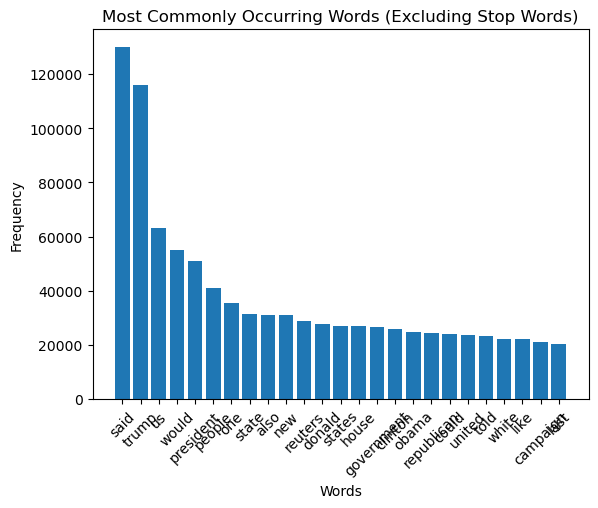

In [53]:
from collections import Counter
all_words = [word for article in cleaned_articles for word in article]
word_counts = Counter(all_words)

common_words = word_counts.most_common(25) 
words, counts = zip(*common_words)

plt.figure()
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Commonly Occurring Words (Excluding Stop Words)")
plt.xticks(rotation = 45)
plt.show()

Most common words in fake vs. true articles

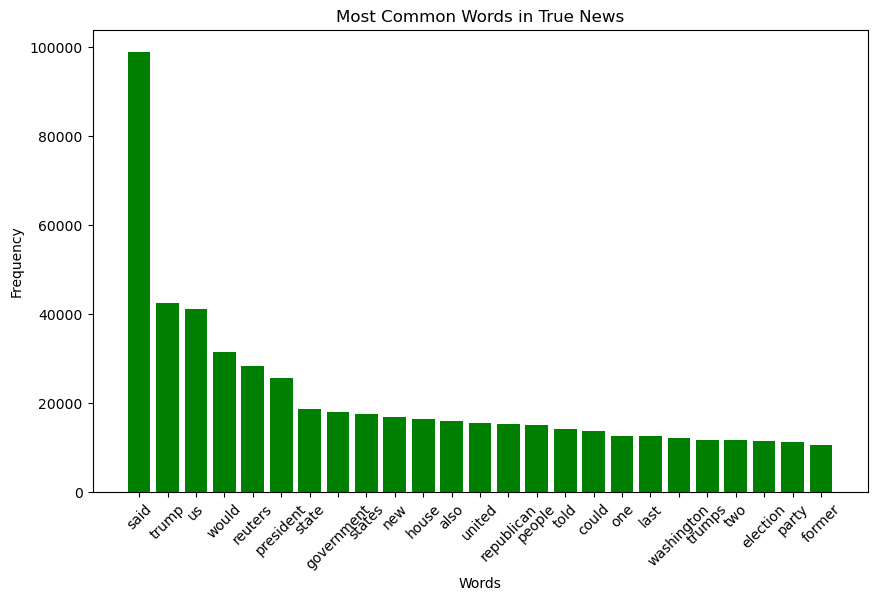

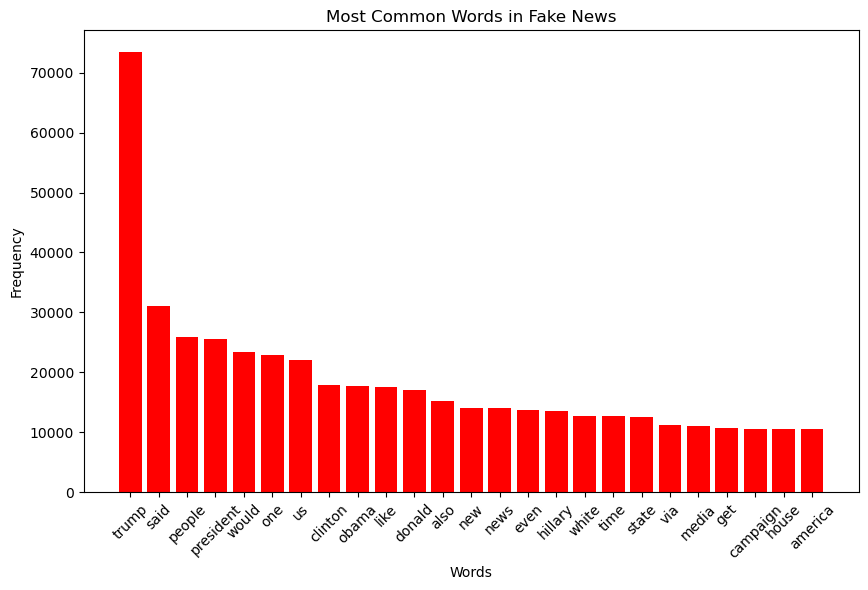

In [55]:
fake_articles = news_df[news_df.label == "Fake"]
fake_tokenized = [nltk.word_tokenize(article) for article in fake_articles["text"]]
fake_cleaned = [[word for word in article if word not in stop_words] 
    for article in fake_tokenized]
fake_words = [word for article in fake_cleaned for word in article]

true_articles = news_df[news_df.label == "True"]
true_tokenized = [nltk.word_tokenize(article) for article in true_articles["text"]]
true_cleaned = [[word for word in article if word not in stop_words] 
    for article in true_tokenized]
true_words = [word for article in true_cleaned for word in article]

fake_word_counts = Counter(fake_words)
true_word_counts = Counter(true_words)

fake_most_common = fake_word_counts.most_common(25) 
fake_words, fake_counts = zip(*fake_most_common)
true_most_common = true_word_counts.most_common(25) 
true_words, true_counts = zip(*true_most_common)

plt.close("all")

# plotting most common words in true articles
plt.figure(figsize = (10, 6))
plt.bar(true_words, true_counts, color="green")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in True News")
plt.xticks(rotation = 45)
plt.show()

# plotting most common words in fake articles
plt.figure(figsize = (10, 6))
plt.bar(fake_words, fake_counts, color="red")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Most Common Words in Fake News")
plt.xticks(rotation = 45)
plt.show()

From the above graphs, we can see the difference in the most common words for fake vs. true news articles. "Election," "republican," "house," "reuters," and "could" seem to be more common in the true news. Meanwhile, "clinton," "obama," "donald," "white," "media," and "campaign" seem to be more common in the fake news. 

Creating a wordcloud

In [58]:
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from textblob import Word

# create dictionaries for word frequencies
fake_top_words = dict(fake_word_counts.most_common(50))
true_top_words = dict(true_word_counts.most_common(50))

# merge word counts while keeping track of origins
combined_word_counts = {word: fake_top_words.get(word, 0) + true_top_words.get(word, 0)
                        for word in set(fake_top_words) | set(true_top_words)}

# custom function to color words based on their origin
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    if word in fake_top_words and word in true_top_words:
        return "rgb(128, 128, 128)"  # gray for shared words
    elif word in fake_top_words:
        return "rgb(255, 0, 0)"  # red for fake news words
    elif word in true_top_words:
        return "rgb(0, 128, 0)"  # green for true news words
    return "rgb(0, 0, 0)"  

# generate word cloud
wordcloud = WordCloud(
    width = 900, height = 450, max_words = 100, background_color = "white"
).generate_from_frequencies(combined_word_counts)

# apply custom coloring 
wordcloud.recolor(color_func = color_func)
 
# plotting the wordcloud
plt.figure(figsize = (12, 6))
plt.imshow(wordcloud, interpolation = "bilinear")
plt.axis("off")
plt.title("Top 100 Words in Fake & True News", fontsize = 16, fontweight = "bold")
plt.show()

ModuleNotFoundError: No module named 'wordcloud'

Finding the most common bigrams within the text:

In [ ]:
from nltk.util import bigrams

def extract_bigrams(text):
    words = [word for word in nltk.word_tokenize(text.lower()) if word.isalnum() and word not in stop_words]
    return list(bigrams(words))

# Extract bigrams from each review
all_bigrams = []
for article in news_df["text"]:
    all_bigrams.extend(extract_bigrams(article))

# Convert bigrams to string format
bigram_strings = [" ".join(bigram) for bigram in all_bigrams]

# Count bigrams
bigram_counts = Counter(bigram_strings)

# Get top 30 bigrams
top_bigrams = pd.DataFrame(bigram_counts.most_common(30), columns=["bigram", "count"])
print(top_bigrams.head())

In [ ]:
from itertools import islice
import networkx as nx
from nltk.tokenize import word_tokenize

# function to process bigrams

def get_top_bigrams(df, label, top_n = 30):
    stop_words = set(stopwords.words('english'))
    
    df = df[df['label'] == label]
    
    bigrams = []
    for text in df['text'].dropna():  # remove na values
        words = [word.lower() for word in word_tokenize(str(text)) if word.isalpha()]
        words = [word for word in words if word not in stop_words and len(word) > 2]  # remove stopwords
        bigrams.extend(zip(words, islice(words, 1, None)))  # create bigrams
        
    bigram_counts = Counter(bigrams)
    
    # select only the top n bigrams
    top_bigrams = dict(bigram_counts.most_common(top_n))
    
    return top_bigrams

# get top 30 bigrams for TRUE and FAKE news
true_bigrams = get_top_bigrams(news_df, "True", top_n=30)
fake_bigrams = get_top_bigrams(news_df, "Fake", top_n=30)

# function to plot bigram graph
def plot_bigram_graph(bigrams, title, color):
    G = nx.DiGraph()
    
    for (word1, word2), count in bigrams.items():
        G.add_edge(word1, word2, weight = count)
    
    plt.figure(figsize = (12, 8))
    pos = nx.spring_layout(G, k = 1.5) 
    edges = G.edges(data = True)
    
    nx.draw(G, pos, node_color = color, edge_color = 'gray', with_labels = True, 
            node_size = 600, font_size = 12) 
    
    # draw edge labels (weights)
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): d['weight'] for u, v, d in edges}, 
                                 font_size = 12) 
    
    plt.title(title, fontsize = 18, fontweight = "bold") 
    plt.show()

# plot true news bigram graph
plot_bigram_graph(true_bigrams, "Frequent Bigrams in True News", color = "lightgreen")

# plot fake news bigram graph
plot_bigram_graph(fake_bigrams, "Frequent Bigrams in Fake News", color = "pink")

The true news bigram graph features terms such as "state secretary", "national security", "prime minister", and "human rights," suggesting coverage of political events, government policies, and international affairs. The presence of "donald trump", "barack obama", and "hillary clinton" indicates reporting on prominent political figures. Additionally, "united states", "north korea", and "european union" point to coverage of global geopolitics. Overall, the true news bigram graph a structured and distributed network with central terms related to governance and diplomacy.

In contrast, the fake news bigram graph displays a looser, more fragmented structure with clusters. The frequent occurrence of "fake news", "media social", and "realdonald trump" suggests possible misinformation and social media discourse. This network includes "bernie sanders", "ted cruz", and "campaign", indicating a focus on less prominent political figures. Additionally, phrases like "attorney general", "supreme court", and "law enforcement" display that legal and judicial topics are common.

# Methods

## Tf-idf

In [ ]:
# data pre-processing
corpus = news_df["text"]
tokenized_corpus = [simple_preprocess(sentence) for sentence in corpus]

stop_words = set(stopwords.words('english'))  # NLTK stop words

filtered_corpus = [
    [word for word in sentence if word.lower() not in stop_words]
    for sentence in tokenized_corpus
]

X = news_df["text"]
y = news_df["label"]

# splitting into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 20, stratify = y)

In [ ]:
# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data (no fitting on test data)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Fit models 

#### Logistic regression model

In [ ]:
# Train logistic regression model
clf_tfidf = LogisticRegression()
clf_tfidf.fit(X_train_tfidf, y_train)

# Predict on test data
y_pred_lr_tfidf = clf_tfidf.predict(X_test_tfidf)

# Evaluate accuracy
accuracy_lr_tfidf = accuracy_score(y_test, y_pred_lr_tfidf)

#### SVM with linear kernel

In [ ]:
# Initialize the SVM classifier
svm_model = SVC(kernel='linear')

# Fit the SVM model on the TF-IDF transformed training data
svm_model.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_svm_tfidf = svm_model.predict(X_test_tfidf)

# Evaluate accuracy
accuracy_svm_tfidf = accuracy_score(y_test, y_pred_svm_tfidf)

print(f"The accuracy for Logistic Regression is {accuracy_lr_tfidf: .4f}, the accuracy for SVM Linear is {accuracy_svm_tfidf: .4f}.")

## Word2Vec

Word2Vec is a word embedding technique that uses shallow neural networks to map words to vectors such that similar words are closer together. This ensures that the semantic meaning is captured by the embedding since words with similar meanings have similar vector representations. There are two main models that fall under Word2Vec: continuous bag of words (CBOW) and skip-gram.

CBOW predicts the target words based on its surrounding context. Given an input of surrounding words within a certain window of the target word, the model predicts the target word.

Skip-gram is the reverse of CBOW. Given a word, the model determines what the surrounding context is. We tried both embedding techniques to determine which one would enhance performance.

## Run and Save Embeddings

In [ ]:
model_cbow = Word2Vec(sentences=filtered_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=0)
model_sg = Word2Vec(sentences=filtered_corpus, vector_size=100, window=5, min_count=1, workers=4, sg=1)

# Parameters:
# - vector_size: Dimensionality of word embeddings
# - window: Context window size
# - min_count: Ignores words appearing less than min_count times
# - workers: Number of CPU cores to use
# - sg: 0 for CBOW (Continuous Bag of Words), 1 for Skip-gram

model_cbow.save("word2vec_cbow.model")
model_sg.save("word2vec_sg.model")

### Fit models

### CBOW

In [ ]:
# Load the model
cbow = Word2Vec.load("word2vec_cbow.model")

def sentence_to_vector(sentence, model):
    """Convert a sentence to a vector by averaging word embeddings."""
    words = simple_preprocess(sentence)  # Tokenization
    word_vectors = [model.wv[word] for word in words if word in model.wv]

    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Average word vectors
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no words are in the model

X_vectors_cbow = np.array([sentence_to_vector(sentence, cbow) for sentence in X])

# train-test split
X_train_cbow, X_test_cbow, y_train, y_test = train_test_split(X_vectors_cbow, y, test_size = 0.25, random_state = 20, stratify = y)

#### Logistic regression model

In [ ]:
# Train logistic regression model
clf_cbow = LogisticRegression()
clf_cbow.fit(X_train_cbow, y_train)

# Predict on test data
y_pred_lr_cbow = clf_cbow.predict(X_test_cbow)

# Evaluate accuracy
accuracy_lr_cbow = accuracy_score(y_test, y_pred_lr_cbow)
print(f"Logistic Accuracy: {accuracy_lr_cbow:.4f}")

#### SVM with linear kernel

In [ ]:
# Train Linear SVM model
svm_cbow_model = SVC(kernel="linear")
svm_cbow_model.fit(X_train_cbow, y_train)

# Predict on test data
y_pred_svm_cbow = svm_cbow_model.predict(X_test_cbow)

# Evaluate accuracy
accuracy_svm_cbow = accuracy_score(y_test, y_pred_svm_cbow)

print(f"The accuracy for Logistic Regression is {accuracy_lr_cbow: .4f}, the accuracy for SVM Linear is {accuracy_svm_cbow: .4f}.")

### Skip-gram

In [ ]:
sg = Word2Vec.load("word2vec_sg.model")

X_vectors_sg = np.array([sentence_to_vector(sentence, sg) for sentence in X])

# train-test split
X_train_sg, X_test_sg, y_train, y_test = train_test_split(X_vectors_sg, y, test_size = 0.25, random_state = 20, stratify = y)

#### Logistic regression model

In [ ]:
# Train logistic regression model
clf_sg = LogisticRegression()
clf_sg.fit(X_train_sg, y_train)

# Predict on test data
y_pred_lr_sg = clf_sg.predict(X_test_sg)

# Evaluate accuracy
accuracy_lr_sg = accuracy_score(y_test, y_pred_lr_sg)

#### SVM with linear kernel

In [ ]:
# Train Linear SVM model
svm_model_sg = SVC(kernel="linear")
svm_model_sg.fit(X_train_sg, y_train)

# Predict on test data
y_pred_svm_sg = svm_model_sg.predict(X_test_sg)

# Evaluate accuracy
accuracy_svm_sg = accuracy_score(y_test, y_pred_svm_sg)

print(f"The accuracy for Logistic Regression is {accuracy_lr_sg: .4f}, the accuracy for SVM Linear is {accuracy_svm_sg: .4f}.")

## GloVe

Global Vectors for Word Representation, or GloVe for short, is a word embedding technique created by Stanford researchers Jeffrey Pennington, Richard Socher, and Christopher D. Manning that captures the meaning of words by analyzing word co-occurrence statistics in a large corpus. In other words, GloVe is a way to turn words into numbers by looking at how often words appear together in a large collection of text. However, unlike word2vec, which learns embeddings through local context windows, GloVe constructs word vectors based on global word co-occurrence matrices, preserving semantic relationships between words. The result is a set of dense vector representations where words with similar meanings are positioned closer together in the vector space. For example, the model understands that the difference between "king" and "man" is similar to the difference between "queen" and "woman". So, if you take the vector for "king", subtract the vector for "man", and add the vector for "woman", you get a result close to the vector for "queen".

For this project, we just load the smallest pre-defined GloVe word embedding library (6 billion tokens), downloaded from https://nlp.stanford.edu/projects/glove/. Then, using TensorFlow’s Tokenizer, the code tokenizes a set of words and outputs vocabulary data. The code defines a function that uses these pre-trained GloVe vectors to create an embedding matrix for a given vocabulary. The algorithm for the function is as follows:   
- Create the dictionary  
- Traverse the glove file of a specific dimension and compare each word with all words in the dictionary, if a match occurs, copy the equivalent vector from the glove and paste into embedding_matrix at the corresponding index.

In [ ]:
# tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

# define function for loading GloVe embeddings
def load_glove_embeddings(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix[idx] = np.array(vector, dtype=np.float32)[:embedding_dim]
    
    return embedding_matrix

embedding_dim = 50
embedding_matrix = load_glove_embeddings('/Users/elliehuang/Desktop/pstat_134/FinalProject/glove.6B/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)

# define function for converting text to embedding representation
def text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim):
    words = text.split()
    word_indices = [tokenizer.word_index[word] for word in words if word in tokenizer.word_index]
    
    if len(word_indices) == 0:
        return np.zeros(embedding_dim)  # return zero vector if no words found
    
    # average word embeddings
    embeddings = np.array([embedding_matrix[idx] for idx in word_indices])
    return np.mean(embeddings, axis=0)

X_vectors_glove = np.array([text_to_embedding(text, tokenizer, embedding_matrix, embedding_dim) for text in corpus])

# train-test split
X_train_glove, X_test_glove, y_train, y_test = train_test_split(X_vectors_glove, y, test_size = 0.25, random_state = 20, stratify = y)

# encode labels
label_encoder = LabelEncoder()
y_glove = label_encoder.fit_transform(news_df["label"])
print(label_encoder.classes_)  

### Fit models

#### Logistic regression model

In [ ]:
# train a Logistic Regression model
log_reg_model = LogisticRegression(max_iter=1000) 
log_reg_model.fit(X_train_glove, y_train)

# make predictions
y_pred_lr_glove = log_reg_model.predict(X_test_glove)

# evaluate model performance
accuracy_lr_glove = accuracy_score(y_test, y_pred_lr_glove)


#### SVM with linear kernel 

In [ ]:
# train SVM model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_glove, y_train)

# make predictions
y_pred_svm_glove = svm_model.predict(X_test_glove)

# evaluate model
accuracy_svm_glove = accuracy_score(y_test, y_pred_svm_glove)

print(f"The accuracy for Logistic Regression is {accuracy_lr_glove: .4f}, the accuracy for SVM Linear is {accuracy_svm_glove: .4f}.")

# Model Results and Evaluation

In [ ]:
# creating dataframe for accuracy scores
accuracy_df = pd.DataFrame({
    "Logistic Regression": [accuracy_lr_tfidf, accuracy_lr_sg, accuracy_lr_cbow, accuracy_lr_glove],
    "SVM": [accuracy_svm_tfidf, accuracy_svm_sg, accuracy_svm_cbow, accuracy_svm_glove]
}, index=["TF-IDF", "CBOW", "Skip-gram", "GloVe"])

print(accuracy_df)

# precision
precision_lr_tfidf = precision_score(y_test, y_pred_lr_tfidf, average='macro')
precision_lr_cbow = precision_score(y_test, y_pred_lr_cbow, average='macro')
precision_lr_sg = precision_score(y_test, y_pred_lr_sg, average='macro')
precision_lr_glove = precision_score(y_test, y_pred_lr_glove, average='macro')

# recall
recall_lr_tfidf = recall_score(y_test, y_pred_lr_tfidf, average='macro')
recall_lr_cbow = recall_score(y_test, y_pred_lr_cbow, average='macro')
recall_lr_sg = recall_score(y_test, y_pred_lr_sg, average='macro')
recall_lr_glove = recall_score(y_test, y_pred_lr_glove, average='macro')

# f1-score
f1_lr_tfidf = f1_score(y_test, y_pred_lr_tfidf, average='macro')
f1_lr_cbow = f1_score(y_test, y_pred_lr_cbow, average='macro')
f1_lr_sg = f1_score(y_test, y_pred_lr_sg, average='macro')
f1_lr_glove = f1_score(y_test, y_pred_lr_glove, average='macro')

# store them in lists
accuracy_scores = [accuracy_lr_tfidf, accuracy_lr_cbow, accuracy_lr_sg, accuracy_lr_glove]
precision_scores = [precision_lr_tfidf, precision_lr_cbow, precision_lr_sg, precision_lr_glove]
recall_scores = [recall_lr_tfidf, recall_lr_cbow, recall_lr_sg, recall_lr_glove]
f1_scores = [f1_lr_tfidf, f1_lr_cbow, f1_lr_sg, f1_lr_glove]

models = ["TF-IDF", "CBOW", "Skip-gram", "GloVe"]

# create subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Evaluation Metrics for Logistic Regression Models", fontsize=16)

# plot Accuracy
axes[0, 0].bar(models, accuracy_scores, color='blue')
axes[0, 0].set_title("Accuracy")
axes[0, 0].set_ylim(0, 1)
axes[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# plot Precision
axes[0, 1].bar(models, precision_scores, color='orange')
axes[0, 1].set_title("Precision")
axes[0, 1].set_ylim(0, 1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# plot Recall
axes[1, 0].bar(models, recall_scores, color='green')
axes[1, 0].set_title("Recall")
axes[1, 0].set_ylim(0, 1)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# plot F1-Score
axes[1, 1].bar(models, f1_scores, color='red')
axes[1, 1].set_title("F1-Score")
axes[1, 1].set_ylim(0, 1)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])

# show plot
plt.show()

Our models achieved relatively high accuracy, all above 90%. The best-performing embedding and model were TF-IDF and a support vector machine with a linear kernel, attaining an accuracy of 99.5%. The high accuracy level may be due to sufficient training values and how balanced the news articles were between fake and true (about 50-50).

For future direction, these models were all implemented on default parameters for logistic regression and SVM, so model adjustments and improvements can be done with further tuning of hyperparameters.